In [6]:
import pandas as pd
import numpy as np
import re
import string
import calendar
import nltk 
import keras 

In [2]:
# TWITTER RACISM DATASET

ori_twit_racist_dataset = '/Users/churnika/Desktop/Projects/Crime_classification/dataset/twitter_racism_parsed_dataset.csv'
ori_twit_racist = pd.read_csv(ori_twit_racist_dataset)
ori_twit_racist = ori_twit_racist.dropna()
ori_twit_racist.columns

Index(['index', 'id', 'Text', 'Annotation', 'oh_label'], dtype='object')

In [3]:
ori_twit_racist = ori_twit_racist.drop(columns=['index','id','Annotation'])
print(ori_twit_racist.columns)

Index(['Text', 'oh_label'], dtype='object')


In [4]:
msg_exp = ori_twit_racist['Text'].str.lower()

In [7]:
# removing the urls that are present.

text_without_urls = []

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text_without_urls = url_pattern.sub('',text)
    return text_without_urls

for i in range(len(msg_exp)):
    try:
        msg_exp[i] = remove_urls(msg_exp[i])
    except KeyError as e:
        # print(f"Error at index {i}: {e}. Skipping...")
        # ori_twit_sexism = ori_twit_sexism.drop(index=i,inplace=True)
        continue

In [8]:
# removing punctuations

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

for i in range(len(msg_exp)):
    try:
        msg_exp[i] = remove_punctuation(msg_exp[i])

    except KeyError as e:
        print(f"Error at index {i}: {e}. Skipping...")
        continue

In [9]:
# TOKENIZATION
# REMOVING URLS
# REMOVING NUMBERS
# REMOVING STOP WORDS

from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

months_days = [calendar.month_name[i].lower() for i in range(1, 13)] + [calendar.day_name[i].lower() for i in range(7)]
remove_words = ["vo","n","m","c","ra","xx","r","date","hii","hi","ye","pa","xxx","p","sir","mam","good","morning","time","ur","you","status","father"]

cleaned_tokens = []

for i in range(len(msg_exp)):
    try:
        tokens = nltk.word_tokenize(msg_exp[i])
        # Filter out URLs
        tokens = [token for token in tokens if not re.match(r'http[s]?://', token)]
        tokens = [token for token in tokens if token.isalpha()]
        tokens = [token for token in tokens if token not in stop_words]
        tokens = [token for token in tokens if token not in months_days]
        tokens = [token for token in tokens if token not in remove_words]
        cleaned_tokens.append(tokens)
    except Exception as e:
        print(f"Error at index {i}: {e}. Skipping...")
        
        continue

[nltk_data] Downloading package punkt to /Users/churnika/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/churnika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# LEMMATIZATION

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [[lemmatizer.lemmatize(token) for token in tokens]for tokens in cleaned_tokens]

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/churnika/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
# REMOVING RARE OR FREQUENTLY USED WORDS

from collections import Counter

freq = Counter([token for tokens in lemmatized_tokens for token in tokens])
freq_threshold = 10

lemmatized_tokens = [[token for token in tokens if freq[token] > freq_threshold] for tokens in lemmatized_tokens]

In [12]:
#REMOVING WHITESPACES

cleaned_lemmatized_tokens = [' '.join(tokens) for tokens in lemmatized_tokens]
cleaned_lemmatized_tokens = [text.split() for text in cleaned_lemmatized_tokens]

In [13]:
# Dictionary mapping abbreviations to their full forms
abbreviation_dict = {
    "don't": "do not",
    "can't": "cannot",
    "u": "you",
    "rt": "right",
    "ur":"your"
}

# Function to expand abbreviations
def expand_abbreviations(tokens):
    expanded_tokens = []
    for token in tokens:
        if token in abbreviation_dict:
            expanded_tokens.extend(abbreviation_dict[token].split())
        else:
            expanded_tokens.append(token)
    return expanded_tokens

# Expand abbreviations in cleaned_lemmatized_tokens
expanded_lemmatized_tokens = [expand_abbreviations(tokens) for tokens in cleaned_lemmatized_tokens]

In [14]:
#REMOVE ACCENTS AND DIACRITICS FROM EXPANDED_LEMMATIZED_TOKENS

from unidecode import unidecode

def remove_accents_diacritics(tokens):
    cleaned_tokens = []
    for token in tokens:
        cleaned_token = unidecode(token)
        cleaned_tokens.append(cleaned_token)
    return cleaned_tokens

expanded_lemmatized_tokens = [remove_accents_diacritics(tokens) for tokens in expanded_lemmatized_tokens]


In [15]:
# SENTIMENT ANALYSIS

from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

tokens = expanded_lemmatized_tokens

# Function to get sentiment
def get_sentiment(token_list):
    text = ' '.join(token_list)
    sentiment = sia.polarity_scores(text)
    return sentiment

sentiments = [get_sentiment(token_list) for token_list in tokens]

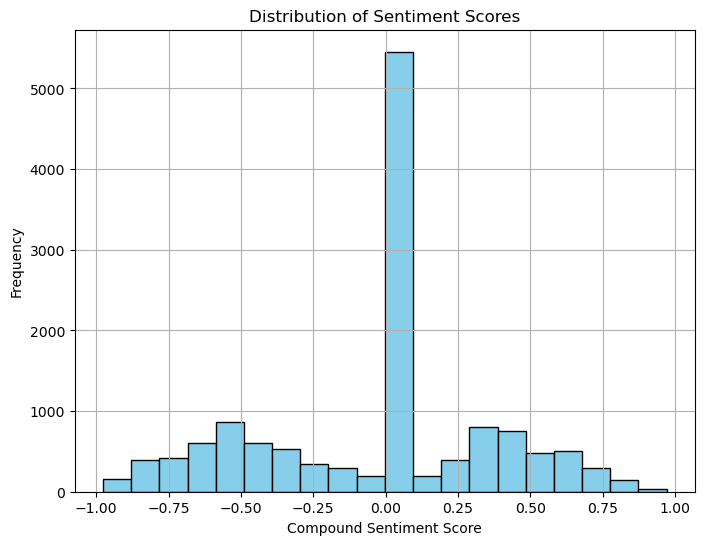

In [16]:
import matplotlib.pyplot as plt

compound_scores = [sentiment['compound'] for sentiment in sentiments]

plt.figure(figsize=(8, 6))
plt.hist(compound_scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [17]:
# MAPPING OF SETIMENT

def map_sentiment_score_to_label(sentiment):
    if sentiment['compound'] >= 0.05:
        return 'positive'
    elif sentiment['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

sentiment_labels = [map_sentiment_score_to_label(sentiment) for sentiment in sentiments]

In [19]:
# Reset the index of the DataFrame

ori_twit_racist.reset_index(drop=True, inplace=True)
ori_twit_sexism_sync = ori_twit_racist.loc[[index for index in ori_twit_racist.index if index < len(sentiments)]]
assert len(sentiments) == len(ori_twit_sexism_sync), "Lengths do not match"

ori_twit_sexism_sync['sentiment'] = sentiment_labels


In [20]:
# TOKENIZATION OF TEXT INTO INTEGER VALUES

from tensorflow.keras.preprocessing.text import Tokenizer

# Create a tokenizer, configured to only take into account the top-10000 most common words
tokenizer = Tokenizer(num_words=10000)

# Build the word index
tokenizer.fit_on_texts(expanded_lemmatized_tokens)

# Turn strings into lists of integer indices
sequences = tokenizer.texts_to_sequences(expanded_lemmatized_tokens)

In [21]:
from keras.preprocessing.sequence import pad_sequences

max_seq_length = 100  # or any other value based on your data

# Pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length)

In [23]:
labels = ori_twit_sexism_sync.oh_label
print(len(padded_sequences))
print(ori_twit_racist.columns)

13471
Index(['Text', 'oh_label'], dtype='object')


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [25]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Define the model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=100))  # Adjust input_dim to the size of your vocabulary and output_dim to the size of the word vectors you want to use
model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2, input_shape=(max_seq_length,)))
model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' for multi-class problems

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # Use 'categorical_crossentropy' for multi-class problems


/Users/churnika/anaconda3/envs/my_project_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8705 - loss: 0.3628 - val_accuracy: 0.9235 - val_loss: 0.1870
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9299 - loss: 0.1696 - val_accuracy: 0.9272 - val_loss: 0.1807
Epoch 3/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9507 - loss: 0.1268 - val_accuracy: 0.9198 - val_loss: 0.1906
Epoch 4/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9516 - loss: 0.1217 - val_accuracy: 0.9267 - val_loss: 0.2026
Epoch 5/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9592 - loss: 0.1094 - val_accuracy: 0.9235 - val_loss: 0.2024
Epoch 6/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9640 - loss: 0.0994 - val_accuracy: 0.9225 - val_loss: 0.2200
Epoch 7/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9699 - loss: 0.0863 - val_accuracy: 0.9216 - val_loss: 0.2420
Epoch 8/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9709 - loss: 0.0817 - val_accu

In [27]:
loss, accuracy = model.evaluate(X_test, y_test)

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9081 - loss: 0.3188


In [28]:
model.save('racism_model.h5')  